<a href="https://colab.research.google.com/github/ShinwooChoi/ESAA-OB/blob/main/11_24_ESAA_OB_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

범위: <딥러닝 파이토치 교과서> 5장 p.200-229

# 5.3 전이 학습

일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요하다. 그러나 충분히 큰 데이터셋을 얻는 것은 쉽지 않으며, 큰 데이터셋을 확보하려면 많은 돈과 시간이 필요하다.

이를 해결하는 것이 전이 학습(transfer learning)이다. 전이 학습은 이미지넷(ImageNet)처럼 매우 큰 데이터셋을 사용해 훈련한 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해 사용하는 방법이다. 이를 사전 훈련된 모델(네트워크)라고 한다.

전이 학습을 위한 방법으로는 특성 추출과 미세 조정 기법이 있다.

## 5.3.1 특성 추출 기법

특성 추출(feature extractor)은 ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막 완전연결층만 새로 만든다. 즉, 합성곱층 부분은 학습하지 않고 마지막 완전연결층만 학습한다.

특성 추출은 다음 두 부분으로 구성된다.
- 합성곱층: 합성곱층과 풀링층으로 구성
- 데이터 분류기(완전연결층): 추출된 특성을 입력받아 이미지의 클래스를 분류

사전 훈련된 네트워크의 합성곱층(가중치 고정)에 새로운 데이터를 통과시키고, 그 출력(특성)을 데이터 분류기에서 훈련시킨다.

사용 가능한 이미지 분류 모델:
- Xception  
- Inception V3  
- ResNet50  
- VGG16  
- VGG19  
- MobileNet  

### transforms

1) torchvision.transforms는 이미지 데이터를 변환하여 모델의 입력으로 사용되게 만든다.

transform = transforms.Compose([
  transforms.Resize([256, 256]),
  transforms.RandomResizedCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

- Resize: 이미지 크기를 256×256으로 조정
- RandomResizedCrop: 랜덤한 크기 및 비율로 자르기
- RandomHorizontalFlip: 이미지를 좌우로 뒤집기
- ToTensor: 이미지를 텐서로 변환

2) datasets.ImageFolder는 폴더 구조 기준으로 이미지 데이터를 로딩한다.

train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

- 첫 번째 파라미터: 데이터 경로  
- transform: 이미지 전처리 방법

3) DataLoader  
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)

- batch_size: 배치 크기  
- num_workers: 데이터를 불러올 때 사용할 프로세스 수  
- shuffle=True: 데이터를 무작위로 섞음

### 반복자 iterator

- iter()는 반복자를 반환, next()는 다음 데이터를 반환  
- train_loader에서 samples와 labels를 하나씩 꺼내오는 구조

### np.transpose  
- 행렬의 행/열을 바꾸는 함수  
- 이미지 텐서를 시각화할 때 (3,224,224) → (224,224,3) 형태로 바꿔야 함  
- samples[i].numpy().transpose(1,2,0) 사용

### ResNet18

ResNet18은 50개 계층으로 구성된 합성곱 신경망이며 ImageNet으로 사전 훈련된 모델을 제공한다. 하지만 입력 제약이 크고 메모리가 충분하지 않으면 속도가 느려질 수 있다.

### requires_grad 조정

- 합성곱층과 풀링층은 requires_grad = False 로 설정해 가중치를 고정(동결)  
- 마지막 완전연결층만 새로 학습

### 파일 처리, 예측

- glob: 특정 확장자 pth 파일만 불러오기  
- torch.max: 예측 결과 중 최댓값의 index 반환  
- preds.eq(labels): 예측이 맞았는지 비교 (sum()으로 개수 계산)

### 정확도 시각화

훈련 데이터와 테스트 데이터 모두 에포크가 진행될수록 정확도가 증가하여 100%에 수렴하는 경향을 보인다.

### tensor.clone(), tensor.detach(), tensor.clone().detach()

- tensor.clone(): 기존 텐서를 복사한 새 텐서를 생성(메모리 새로 할당). 계산 그래프 상주 O  
- tensor.detach(): 기존 텐서를 공유해서 사용(메모리 공유). 계산 그래프 상주 X  
- tensor.clone().detach(): 복사 + 계산 그래프 분리

## 5.3.2 미세조정기법

- 데이터셋이 작고 사전 훈련 모델과 유사성이 작을 경우  
  → 합성곱층 일부만 학습시키며 어떤 계층을 학습할지 조정 필요  
- 데이터셋이 작고 사전 훈련 모델과 유사성이 클 경우  
  → 데이터 분류기(완전연결층)만 학습  
- 미세 조정(fine-tuning): 특성 추출 기반에서 더 나아가 사전 훈련된 가중치도 재학습  
- 특성 추출(feature extractor): 합성곱층은 고정, 마지막 FC 층만 새로 학습

### torchvision.transforms

- Resize: 입력 이미지를 지정 크기로 조정  
- RandomResizedCrop: 비율·크기를 무작위로 자르며 데이터 확장  
- RandomHorizontalFlip: 이미지 좌우 반전  
- ToTensor: 텐서로 변환  
- ImageFolder: 데이터 경로 구조를 읽어 레이블 자동 분류  
- DataLoader 파라미터  
  - batch_size: 한 번에 불러올 데이터 개수  
  - num_workers: 데이터 불러올 하위 프로세스 수  
  - shuffle: 데이터를 무작위 섞기

### iterator(iter), next()

- iter(loader): 반복자 생성  
- next(iterator): 다음 데이터를 반환  
- train_loader에서 samples, labels 순차적으로 꺼내오는 의미

### np.transpose

- 행/열을 바꾸어 배열 차원을 조정  
- 예: (3, 224, 224) → (224, 224, 3)  
- 이미지 시각화 시 필요 (matplotlib은 HWC 형식 요구)

### ResNet18

- 50개 계층으로 구성된 CNN  
- ImageNet 기반 사전학습 모델 제공  
- 입력 크기 큼 / 메모리 많이 필요  
- transfer learning 에 많이 사용됨  
- FC 층만 교체하여 개/고양이 분류에 활용 가능

### requires_grad = False

- 일부 계층은 고정하고 나머지만 학습하고 싶을 때 사용  
- 주로 합성곱층은 고정, 마지막 FC 층만 학습

### glob, torch.max, preds.eq

- glob: 폴더에서 특정 확장자 파일만 추출  
- torch.max(tensor, dim): 최댓값과 해당 index 반환  
- preds.eq(labels): 예측값과 정답이 일치하는지 비교

### clip 함수

- np.clip(x, min, max)  
- 지정 범위를 벗어난 값을 min/max로 강제  
- 이미지 데이터 0~1 사이 강제할 때 사용

### add_subplot 파라미터

- add_subplot(행, 열, index, xticks=[], yticks=[])  
  - 첫 번째: 행 수  
  - 두 번째: 열 수  
  - 세 번째: 몇 번째 위치에 그릴지(index)  
  - xticks, yticks: 축 숫자 제거 여부

### 계산 그래프 (Computational Graph)

- 연산 과정을 그래프로 표현  
- 국소적 계산 가능 → 일부 값 변화 시 전체 재계산 필요 없음  
- 역전파(backprop) 과정에서 연쇄 법칙(chain rule) 적용  
- 노드(node): 값  
- 엣지(edge): 연산

### 연쇄 법칙 (Chain Rule)

- 여러 함수가 합성된 함수의 미분을 구하는 방법  
- 예:  
  z = (x + y)^2  
  t = x + y  
  z = t^2  
  dz/dx = dz/dt · dt/dx  
- 미분을 단계별로 곱해 계산


In [31]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path='/content/drive/MyDrive/data/catanddog/train'

transform=transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])
train_dataset=torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


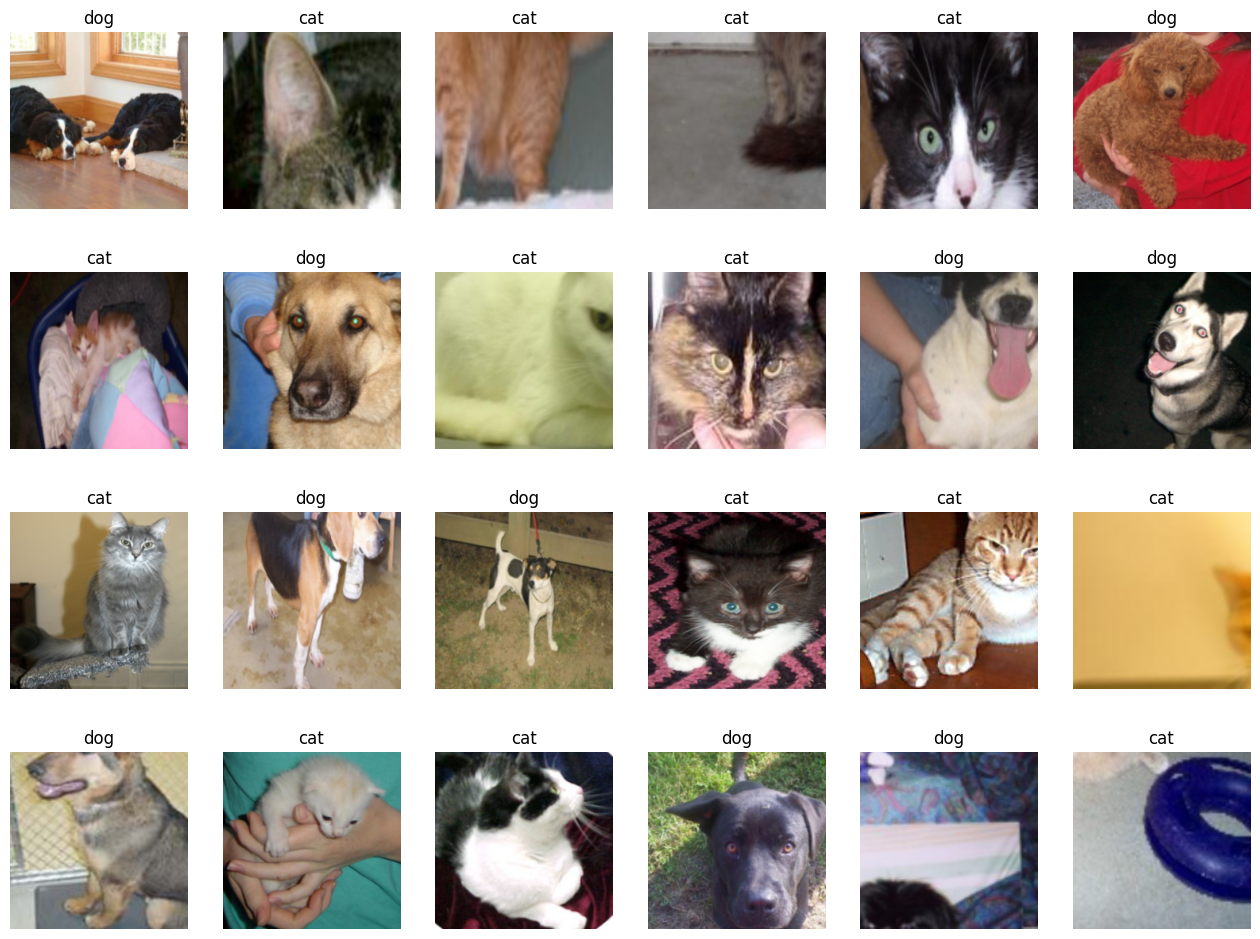

In [5]:
# 학습에 사용될 이미지 출력
import numpy as np
samples, labels=next(iter(train_loader))
classes={0: 'cat', 1: 'dog'}
fig=plt.figure(figsize=(16,24))
for i in range(24):
    a=fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
resnet18=models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [7]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad=False

set_parameter_requires_grad(resnet18)

In [8]:
resnet18.fc=nn.Linear(512, 2)

In [9]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0146, -0.0261,  0.0185,  ...,  0.0050, -0.0430, -0.0086],
        [-0.0351, -0.0362, -0.0177,  ...,  0.0417,  0.0006,  0.0141]])
fc.bias tensor([-0.0155, -0.0008])


In [10]:
model=models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad=False

model.fc=torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad=True

optimizer=torch.optim.Adam(model.fc.parameters())
cost=torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13,
                is_train=True):
    since=time.time()
    acc_history=[]
    loss_history=[]
    best_acc=0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss=0.0
        running_corrects=0

        for inputs, labels in dataloaders:
            inputs=inputs.to(device)
            labels=labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs, labels)
            _, preds=torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)

        epoch_loss=running_loss / len(dataloaders.dataset)
        epoch_acc=running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
           best_acc=epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/data/catanddog',
                                                    '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed=time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [22]:
params_to_update=[]
for name, param in resnet18.named_parameters():
    if param.requires_grad==True:
        params_to_update.append(param)
        print("\t", name)

optimizer=optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [23]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion=nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist=train_model(resnet18, train_loader, criterion,
                                            optimizer, device)

Epoch 0/12
----------
Loss: 0.3487 Acc: 0.8519

Epoch 1/12
----------
Loss: 0.3182 Acc: 0.8519

Epoch 2/12
----------
Loss: 0.3152 Acc: 0.8519

Epoch 3/12
----------
Loss: 0.2770 Acc: 0.8753

Epoch 4/12
----------
Loss: 0.2508 Acc: 0.8857

Epoch 5/12
----------
Loss: 0.2340 Acc: 0.9065

Epoch 6/12
----------
Loss: 0.1870 Acc: 0.9429

Epoch 7/12
----------
Loss: 0.2392 Acc: 0.8883

Epoch 8/12
----------
Loss: 0.2558 Acc: 0.8831

Epoch 9/12
----------
Loss: 0.1749 Acc: 0.9377

Epoch 10/12
----------
Loss: 0.2073 Acc: 0.9117

Epoch 11/12
----------
Loss: 0.2276 Acc: 0.8779

Epoch 12/12
----------
Loss: 0.2043 Acc: 0.9013

Training complete in 8m 24s
Best Acc: 0.942857


In [24]:
test_path='/content/drive/MyDrive/data/catanddog/test'

transform=transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
])
test_dataset=torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader=torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [25]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since=time.time()
    acc_history=[]
    best_acc=0.0

    saved_models=glob.glob('/content/drive/MyDrive/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects=0

        for inputs, labels in dataloaders:
            inputs=inputs.to(device)
            labels=labels.to(device)

            with torch.no_grad():
                 outputs=model(inputs)

            _, preds=torch.max(outputs.data, 1)
            preds[preds >= 0.5]=1
            preds[preds < 0.5]=0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc=running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc=epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed=time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                          time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [26]:
val_acc_hist=eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/data/catanddog/00.pth', '/content/drive/MyDrive/data/catanddog/01.pth', '/content/drive/MyDrive/data/catanddog/02.pth', '/content/drive/MyDrive/data/catanddog/03.pth', '/content/drive/MyDrive/data/catanddog/04.pth', '/content/drive/MyDrive/data/catanddog/05.pth', '/content/drive/MyDrive/data/catanddog/06.pth', '/content/drive/MyDrive/data/catanddog/07.pth', '/content/drive/MyDrive/data/catanddog/08.pth', '/content/drive/MyDrive/data/catanddog/09.pth', '/content/drive/MyDrive/data/catanddog/10.pth', '/content/drive/MyDrive/data/catanddog/11.pth', '/content/drive/MyDrive/data/catanddog/12.pth']
Loading model /content/drive/MyDrive/data/catanddog/00.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/data/catanddog/01.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/data/catanddog/02.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/data/catanddog/03.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/data/catanddog/04.pth
Acc: 0.9592

Loa

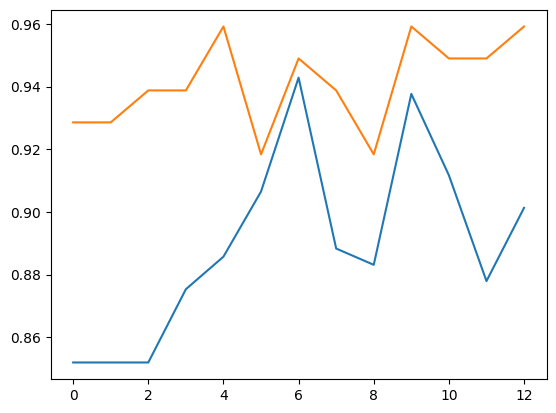

In [27]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

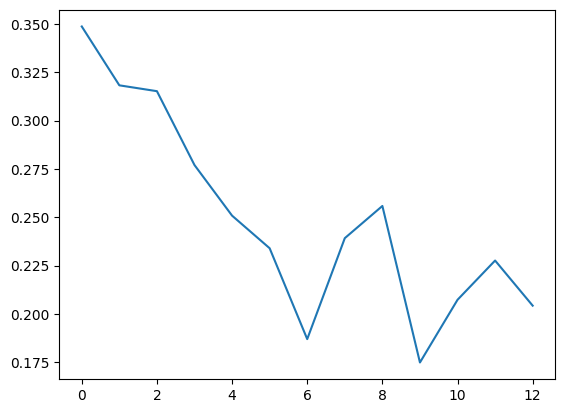

In [28]:
plt.plot(train_loss_hist)
plt.show()

In [29]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1, 2, 0)
    image=image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image=image.clip(0, 1)
    return image

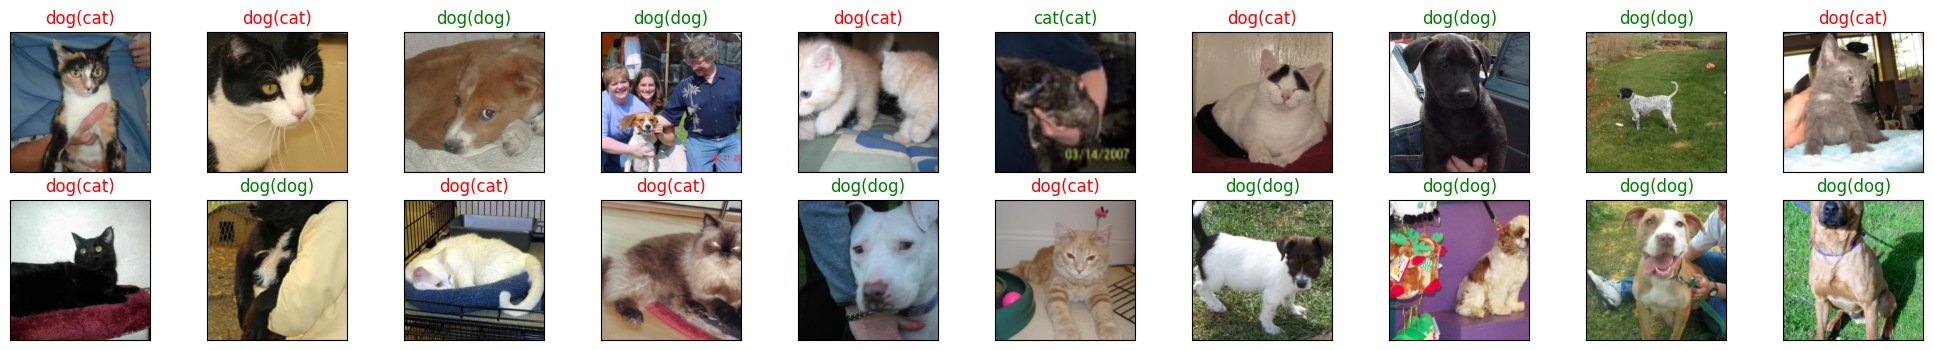

<Figure size 640x480 with 0 Axes>

In [30]:
# 개와 고양이 예측 결과 출력
classes={0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images, labels=next(dataiter)
output=model(images)
_, preds=torch.max(output, 1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].
                                                                              item()])), color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)